# Naive Bayes Classification
Date: August 14th, 2022

# Introduction

Naive Bayes is simple, fast, and provides good results. It is easy to implement in an IT production environment. It is used for classification tasks (e.g., text, spam filter).
Some advantages:
*   Fast for both training and prediction
*   Provide straightforward probabilistic prediction
*   Easy to implement

Disadvantages:
*   It assumes that all predictors (or features) are independent.
*   It faces the ‘zero-frequency problem’ where it assigns zero probability to a categorical variable whose category in the test data set wasn’t available in the training dataset. It would be best if you used a smoothing technique to overcome this issue.


# Getting started

*   fetch_20newsgroups: This dataset comprises around 18000 newsgroups posts on 20 topics split in two subsets: one for training and the other one for testing. More information: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html




In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# Multinomial Naive Bayes

We model the data distribuiton with a best-fit multinomial distribution. Multinomial Naive Bayes consider a feature vector where a given term represents the number of times it appears or very often i.e. frequency

One place where multinomial naive Bayes is often used is in text classification, where the features are related to word counts or frequencies within the documents to be classified.

In [ ]:
from sklearn.datasets import fetch_20newsgroups

data = fetch_20newsgroups()
data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

We will select just a few of these categories, and download the training and testing set

In [ ]:
categories = ['talk.religion.misc', 'soc.religion.christian',
              'sci.space', 'comp.graphics']
train = fetch_20newsgroups(subset='train',categories=categories)
test = fetch_20newsgroups(subset='test',categories=categories)

We need to be able to convert the content of each string into a vector of numbers. For this we will use the TF-IDF vectorizer and create a pipeline that attaches it to a multinomial naive Bayes classifier (https://en.wikipedia.org/wiki/Tf–idf)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

classifier = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('estimator', MultinomialNB())
])

from sklearn import set_config
set_config(display='diagram')
classifier

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('estimator', MultinomialNB())])

We can apply the model to the training data, and predict labels for the test data

In [ ]:
classifier.fit(train.data, train.target)
train_predictions = classifier.predict(test.data)

We can evaluate them to learn about the performance of the estimator. Here is the confusion matrix between the true and predicted labels for the test data:

[[344  13  32   0]
 [  6 364  24   0]
 [  1   5 392   0]
 [  4  12 187  48]]
              precision    recall  f1-score   support

           0       0.97      0.88      0.92       389
           1       0.92      0.92      0.92       394
           2       0.62      0.98      0.76       398
           3       1.00      0.19      0.32       251

    accuracy                           0.80      1432
   macro avg       0.88      0.75      0.73      1432
weighted avg       0.86      0.80      0.77      1432



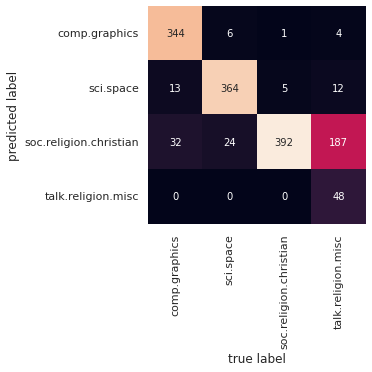

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

matrix = confusion_matrix(test.target, train_predictions)
print(matrix)
print(classification_report(test.target, train_predictions))

sns.heatmap(matrix.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=train.target_names, yticklabels=train.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

# Laboratory

> *  Take a look at the following URL: https://www.cazadoresdefakenews.info/botnetgl-twitter-suspendio-491-cuentas-de-botnet-ecuatoriana/
*   Analyze the features of the account detected as bots

Using API twitter
*   Obtain a new dataset of bots and real accounts
*   Use the generated dataset to train a Naive Bayes classifier

**NEW USER DATASET GENERATION**

In [ ]:
import requests
import os
import json
import time
import datetime
import logging


logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


# To set your environment variables in your terminal run the following line:
# export 'BEARER_TOKEN'='<your_bearer_token>'
# bearer_token = 'AAAAAAAAAAAAAAAAAAAAALsVPwEAAAAAZons2DuoflqrVYXW8cUNlWyMAuE%3DacnAzHik2RFqZLqK2Ly4jRtl2RKSi3yITA5PfXg6oEalsFa15j'
bearer_token = 'AAAAAAAAAAAAAAAAAAAAAGTpfQEAAAAAKZIgQ%2BrILA7ls9osowsx%2F4dw6tw%3D16Wc6Gjt8uhSvVmkSIE1z3H2jVJrRrm4K5SwuGpOndbXbSb18R'
# os.environ.get("BEARER_TOKEN")

search_url = "https://api.twitter.com/2/tweets/search/all"

# Optional params: start_time,end_time,since_id,until_id,max_results,next_token,
# expansions,tweet.fields,media.fields,poll.fields,place.fields,user.fields
# query_params = {'query': '(from:twitterdev -is:retweet) OR #twitterdev','tweet.fields': 'author_id'}

q = '#ParoNacional -is:retweet is:verified'
# q = '#terremoto #Ecuador -is:retweet'

query_params = {
    'query': q,
    'user.fields': 'username,public_metrics,created_at,verified,description',
    # 'tweet.fields': 'created_at,entities,public_metrics',
    'start_time':'2019-01-01T12:00:00Z',
    'expansions':'author_id',
    'max_results': 500
    }


def bearer_oauth(r):
    """
    Method required by bearer token authentication.
    """

    r.headers["Authorization"] = f"Bearer {bearer_token}"
    r.headers["User-Agent"] = "v2FullArchiveSearchPython"
    return r


def connect_to_endpoint(url, params):
    response = requests.request("GET", search_url, auth=bearer_oauth, params=params)
    print(response.status_code)
    if response.status_code != 200:
        raise Exception(response.status_code, response.text)
    return response.json()

def main():

    with open("ParoNacional_bots.json",'a',encoding='utf-8') as f:

        atomic_users = []
        count_loop = 0

        while True:

            json_response = connect_to_endpoint(search_url, query_params)

            data = json_response["data"] #always data
            meta = json_response["meta"] #always meta
            includes = json_response['includes']

# ---------------------- FOR USERS FEATURES EXTRACTION -------------------------

            for user in includes['users']:
                id = user["id"]
                username = user["username"]
                public_metrics = user["public_metrics"]
                seguidores = public_metrics["followers_count"]
                siguiendo = public_metrics["following_count"]
                tweets = public_metrics["tweet_count"]
                Fecha = user["created_at"]
                name = user["name"]
                verified = user["verified"]
                biography = user["description"]

                # id,username,public_metrics,created_at,name,verified,location,description',

                atomic = {
                    "Twitter ID":id,
                    "username":username,
                    # "public_metrics":public_metrics,
                    "seguidores":seguidores,
                    "siguiendo":siguiendo,
                    "tweets":tweets,
                    "Fecha de creación":Fecha,
                    #"category":category,
                    "Nombre":name,
                    "Verificado":verified,
                    "Biografía":biography
                }
                    # "followers":followers,

                    # "tweets_count":tweets_count
                    # "hashtags":hashtags,
                    # "mentions":mentions,
                    # "screen_name":screen_name,
                    # "permalink":permalink
                # }
            #     #print(atomic)

                atomic_users.append(atomic)

            user_num = len(data)
            print(user_num)
            count_loop +=1

            logger.info(f"count loop: {count_loop}")
            logger.info(f'user_num: {user_num}')

            if 'next_token' in meta:
                next_token = meta["next_token"]
                logger.info(f'\nnext_token: {next_token}')
                if count_loop == 5:
                  break
            else:
                break

            query_params['next_token'] = next_token

            #wait 1 seg
            time.sleep(1)

        print(atomic_users)

        #save all at once
        f.write(json.dumps(atomic_users,indent=4,ensure_ascii=False,default=str))

if __name__ == "__main__":
    main()

200
498
200
500
200
500
200
499
200
481
[{'Twitter ID': '47384568', 'username': 'revistavistazo', 'seguidores': 618479, 'siguiendo': 462, 'tweets': 115856, 'Fecha de creación': '2009-06-15T17:09:28.000Z', 'Nombre': 'Revista Vistazo', 'Verificado': True, 'Biografía': 'Revista ecuatoriana de análisis político, social, económico y global.'}, {'Twitter ID': '46136235', 'username': 'Ccajar', 'seguidores': 68120, 'siguiendo': 2555, 'tweets': 117812, 'Fecha de creación': '2009-06-10T15:22:25.000Z', 'Nombre': 'ColectivoDeAbogad@s', 'Verificado': True, 'Biografía': 'Propiedad de Corporación Colectivo de Abogados José Alvear Restrepo.\n\nEn defensa de los Derechos Humanos, paz con justicia social y ambiental #ParaQueNoSeRepita'}, {'Twitter ID': '143265708', 'username': 'Movicecol', 'seguidores': 30439, 'siguiendo': 1774, 'tweets': 30932, 'Fecha de creación': '2010-05-13T01:19:23.000Z', 'Nombre': 'Movice', 'Verificado': True, 'Biografía': 'Somos semilla, somos memoria, somos el sol que renace ant

**VISUALIZING THE 491: BOTSGL - BOT USERS DATASET**

In [ ]:
import requests
import json
import pandas as pd
import numpy as np

with open('csvjson.json') as data_file:
  data = json.load(data_file)

# Flattening JSON data
data_users_bots = pd.json_normalize(data)
data_users_bots

In [ ]:
data_users_bots.drop(['#', 'Place'], inplace=True, axis=1)

In [ ]:
data_users_bots

,Twitter ID,username,seguidores,siguiendo,tweets,Fecha de creación,Nombre,Biografía
0,1549333806498324500,@claraandrade81,28,61,102,19-07-2022 10:05,Clara Andrade,Que todo fluya 🌊 y nada influya 💥
1,1549259214027165700,@susanac2536,0,35,92,19-07-2022 5:06,Susana Carrasco,En la NATURALEZA
2,1549260000000000000,@mmluisa90,2,29,88,19-07-2022 4:53,Martha Luisa,Me encantan los animales
3,1549249560773628000,@carlosant7922,2,29,39,19-07-2022 4:27,Antonio Fuentes,Música banda
4,1549129414688084000,@jyanzapata,18,51,122,18-07-2022 20:30,Juan Camilo Yanzapata,
...,...,...,...,...,...,...,...,...
486,1488697574471123000,@abigail_domingz,22,48,576,2/2/22 2:16,Abigail Domínguez,Es algo entre tu y yo.
487,1487194571389948000,@valentina_ben4,22,47,647,28-01-2022 22:43,Valentina Benavides,"La vida es bella, disfrútala al máximo."
488,1487186750955044900,@alejandra_cabr3,20,48,660,28-01-2022 22:12,Alejandra Cabrera,El mejor hobby es escuchar música.
489,1487096990647345200,@andrea_river4,18,47,668,28-01-2022 16:15,Andrea Rivera,A la tercera va la vencida.


**CREATING REAL TABLE**

In [ ]:
with open('ParoNacional_bots.json') as data_file:
  data = json.load(data_file)

# Flattening JSON data
data_users_real = pd.json_normalize(data)
data_users_real

In [ ]:
data_users_real.drop(['Verified'], inplace=True, axis=1)

In [ ]:
data_users_real

,Twitter ID,username,seguidores,siguiendo,tweets,Fecha de creación,Nombre,Biografía
0,143265708,Movicecol,30409,1774,30923,2010-05-13T01:19:23.000Z,Movice,"Somos semilla, somos memoria, somos el sol que..."
1,60785796,ZNVISION,14913,6278,103976,2009-07-28T02:32:25.000Z,Zona Norte Visión,Medio de comunicación. Portal de noticias del ...
2,45013575,teleSURtv,2065078,347,1398907,2009-06-05T22:21:49.000Z,teleSUR TV,"Con más de 40 corresponsales en el mundo, alza..."
3,1724076636,RollingStoneCol,37538,455,27703,2013-09-03T02:23:36.000Z,Rolling Stone en Español - Colombia,"Mil acentos, cientos de culturas y una sola vo..."
4,154731462,Ale_Bodart,24549,915,25878,2010-06-12T01:59:40.000Z,Alejandro Bodart,Secretario General del @MSTArgentina en el FIT...
...,...,...,...,...,...,...,...,...
468,141039072,SANTAMARIAURIBE,39466,5318,39071,2010-05-07T01:27:15.000Z,José Miguel Santamaría Uribe,@MovSalvacionNal\n#ProVida \n#PoliticamenteInc...
469,169147882,UniversidadEan,27595,950,28626,2010-07-21T17:22:33.000Z,Universidad Ean,Emprendiendo un mundo mejor 🌎| Vigilada Minedu...
470,247888588,Miquel_R,134478,6439,61535,2011-02-05T19:55:23.000Z,Miquel Ramos,"Periodista. La Marea, Público, El Salto. Col·l..."
471,150992719,tdh_de,6128,972,4219,2010-06-02T10:08:12.000Z,terre des hommes,➡️ Kinderrechtsorganisation\n💪 Wir machen Kind...


**Changing the Date Format equal to that of the BOTS data set**

In [ ]:
data_fecha = []
for i in range (0,len(data_users_real['Date of creation'])):
  fecha_original = data_users_real.iloc[i]['Date of creation']
  dia = fecha_original[8:10]
  mes = fecha_original[5:7]
  año = fecha_original[0:4]
  hora = fecha_original[11:16]
  fecha_final = dia + '-' + mes + '-' + año + ' ' + hora
  data_users_real.loc[i,'Date of creation'] = fecha_final

In [ ]:
data_users_real

,Twitter ID,username,seguidores,siguiendo,tweets,Fecha de creación,Nombre,Biografía
0,143265708,Movicecol,30409,1774,30923,13-05-2010 01:19,Movice,"Somos semilla, somos memoria, somos el sol que..."
1,60785796,ZNVISION,14913,6278,103976,28-07-2009 02:32,Zona Norte Visión,Medio de comunicación. Portal de noticias del ...
2,45013575,teleSURtv,2065078,347,1398907,05-06-2009 22:21,teleSUR TV,"Con más de 40 corresponsales en el mundo, alza..."
3,1724076636,RollingStoneCol,37538,455,27703,03-09-2013 02:23,Rolling Stone en Español - Colombia,"Mil acentos, cientos de culturas y una sola vo..."
4,154731462,Ale_Bodart,24549,915,25878,12-06-2010 01:59,Alejandro Bodart,Secretario General del @MSTArgentina en el FIT...
...,...,...,...,...,...,...,...,...
468,141039072,SANTAMARIAURIBE,39466,5318,39071,07-05-2010 01:27,José Miguel Santamaría Uribe,@MovSalvacionNal\n#ProVida \n#PoliticamenteInc...
469,169147882,UniversidadEan,27595,950,28626,21-07-2010 17:22,Universidad Ean,Emprendiendo un mundo mejor 🌎| Vigilada Minedu...
470,247888588,Miquel_R,134478,6439,61535,05-02-2011 19:55,Miquel Ramos,"Periodista. La Marea, Público, El Salto. Col·l..."
471,150992719,tdh_de,6128,972,4219,02-06-2010 10:08,terre des hommes,➡️ Kinderrechtsorganisation\n💪 Wir machen Kind...


**MERGING OF THE TWO DATASETS**

In [ ]:
data_users_bots = data_users_bots.append(data_users_real, ignore_index = True)

In [ ]:
data_users_bots

,Twitter ID,username,seguidores,siguiendo,tweets,Fecha de creación,Nombre,Biografía
0,1549333806498324500,@claraandrade81,28,61,102,19-07-2022 10:05,Clara Andrade,Que todo fluya 🌊 y nada influya 💥
1,1549259214027165700,@susanac2536,0,35,92,19-07-2022 5:06,Susana Carrasco,En la NATURALEZA
2,1549260000000000000,@mmluisa90,2,29,88,19-07-2022 4:53,Martha Luisa,Me encantan los animales
3,1549249560773628000,@carlosant7922,2,29,39,19-07-2022 4:27,Antonio Fuentes,Música banda
4,1549129414688084000,@jyanzapata,18,51,122,18-07-2022 20:30,Juan Camilo Yanzapata,
...,...,...,...,...,...,...,...,...
959,141039072,SANTAMARIAURIBE,39466,5318,39071,07-05-2010 01:27,José Miguel Santamaría Uribe,@MovSalvacionNal\n#ProVida \n#PoliticamenteInc...
960,169147882,UniversidadEan,27595,950,28626,21-07-2010 17:22,Universidad Ean,Emprendiendo un mundo mejor 🌎| Vigilada Minedu...
961,247888588,Miquel_R,134478,6439,61535,05-02-2011 19:55,Miquel Ramos,"Periodista. La Marea, Público, El Salto. Col·l..."
962,150992719,tdh_de,6128,972,4219,02-06-2010 10:08,terre des hommes,➡️ Kinderrechtsorganisation\n💪 Wir machen Kind...


**BIOGRAPHY CLEANUP AND EMOJI REMOVAL**

In [ ]:
pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 197 kB 5.2 MB/s 
  Created wheel for emoji: filename=emoji-2.0.0-py3-none-any.whl size=193022 sha256=1b3d07455da71252de32783ccfd4c7d7edd95754b25a2c3525e72f84ab4a4628
  Stored in directory: /root/.cache/pip/wheels/ec/29/4d/3cfe7452ac7d8d83b1930f8a6205c3c9649b24e80f9029fc38
Successfully built emoji


In [ ]:
import emoji

def deEmojify(text):
    # return emoji.get_emoji_regexp().sub(r'', text.decode('utf8'))
    # return emoji.get_emoji_regexp().sub(u'', text)

    # allchars = [str for str in text.decode('utf-8')]
    # emoji_list = [c for c in allchars if c in emoji.UNICODE_EMOJI]
    # clean_text = ' '.join([str for str in text.decode('utf-8').split() if not any(i in str for i in emoji_list)])
    # return clean_text

    return emoji.replace_emoji(text, replace="")

In [ ]:
data_text = []
for i in range (0,len(data_users_bots['Biografía'])):
  text_original = data_users_bots.iloc[i]['Biografía']
  text_final = deEmojify(text_original)       # SOLUCIONAR ERROR AQUI, ESO PEUDE Q SOLUCIONE LA PARTE DEL CLASIFICADOR
  data_users_bots.loc[i,'Biografía'] = text_final

In [ ]:
data_users_bots

,Twitter ID,username,seguidores,siguiendo,tweets,Fecha de creación,Nombre,Biografía
0,1549333806498324500,@claraandrade81,28,61,102,19-07-2022 10:05,Clara Andrade,Que todo fluya y nada influya
1,1549259214027165700,@susanac2536,0,35,92,19-07-2022 5:06,Susana Carrasco,En la NATURALEZA
2,1549260000000000000,@mmluisa90,2,29,88,19-07-2022 4:53,Martha Luisa,Me encantan los animales
3,1549249560773628000,@carlosant7922,2,29,39,19-07-2022 4:27,Antonio Fuentes,Música banda
4,1549129414688084000,@jyanzapata,18,51,122,18-07-2022 20:30,Juan Camilo Yanzapata,
...,...,...,...,...,...,...,...,...
959,141039072,SANTAMARIAURIBE,39466,5318,39071,07-05-2010 01:27,José Miguel Santamaría Uribe,@MovSalvacionNal\n#ProVida \n#PoliticamenteInc...
960,169147882,UniversidadEan,27595,950,28626,21-07-2010 17:22,Universidad Ean,Emprendiendo un mundo mejor | Vigilada Mineduc...
961,247888588,Miquel_R,134478,6439,61535,05-02-2011 19:55,Miquel Ramos,"Periodista. La Marea, Público, El Salto. Col·l..."
962,150992719,tdh_de,6128,972,4219,02-06-2010 10:08,terre des hommes,Kinderrechtsorganisation\n Wir machen Kinder ...


**ADD NEW COLUMN is_Bot WITH VALUE 1 IN THE ENTIRE DATASET**

In [ ]:
new_df=data_users_bots.assign(is_Bot=1)

In [ ]:
new_df

,Twitter ID,username,seguidores,siguiendo,tweets,Fecha de creación,Nombre,Biografía,is_Bot
0,1549333806498324500,@claraandrade81,28,61,102,19-07-2022 10:05,Clara Andrade,Que todo fluya y nada influya,1
1,1549259214027165700,@susanac2536,0,35,92,19-07-2022 5:06,Susana Carrasco,En la NATURALEZA,1
2,1549260000000000000,@mmluisa90,2,29,88,19-07-2022 4:53,Martha Luisa,Me encantan los animales,1
3,1549249560773628000,@carlosant7922,2,29,39,19-07-2022 4:27,Antonio Fuentes,Música banda,1
4,1549129414688084000,@jyanzapata,18,51,122,18-07-2022 20:30,Juan Camilo Yanzapata,,1
...,...,...,...,...,...,...,...,...,...
959,141039072,SANTAMARIAURIBE,39466,5318,39071,07-05-2010 01:27,José Miguel Santamaría Uribe,@MovSalvacionNal\n#ProVida \n#PoliticamenteInc...,1
960,169147882,UniversidadEan,27595,950,28626,21-07-2010 17:22,Universidad Ean,Emprendiendo un mundo mejor | Vigilada Mineduc...,1
961,247888588,Miquel_R,134478,6439,61535,05-02-2011 19:55,Miquel Ramos,"Periodista. La Marea, Público, El Salto. Col·l...",1
962,150992719,tdh_de,6128,972,4219,02-06-2010 10:08,terre des hommes,Kinderrechtsorganisation\n Wir machen Kinder ...,1


**CHANGE is_Bot = 0 IF IT BELONGS TO THE SECOND DATASET**

In [ ]:
for i in range(492,964):
  new_df.at[i,'is_Bot']=0

In [ ]:
new_df

,Twitter ID,username,seguidores,siguiendo,tweets,Fecha de creación,Nombre,Biografía,is_Bot
0,1549333806498324500,@claraandrade81,28,61,102,19-07-2022 10:05,Clara Andrade,Que todo fluya y nada influya,1
1,1549259214027165700,@susanac2536,0,35,92,19-07-2022 5:06,Susana Carrasco,En la NATURALEZA,1
2,1549260000000000000,@mmluisa90,2,29,88,19-07-2022 4:53,Martha Luisa,Me encantan los animales,1
3,1549249560773628000,@carlosant7922,2,29,39,19-07-2022 4:27,Antonio Fuentes,Música banda,1
4,1549129414688084000,@jyanzapata,18,51,122,18-07-2022 20:30,Juan Camilo Yanzapata,,1
...,...,...,...,...,...,...,...,...,...
959,141039072,SANTAMARIAURIBE,39466,5318,39071,07-05-2010 01:27,José Miguel Santamaría Uribe,@MovSalvacionNal\n#ProVida \n#PoliticamenteInc...,0
960,169147882,UniversidadEan,27595,950,28626,21-07-2010 17:22,Universidad Ean,Emprendiendo un mundo mejor | Vigilada Mineduc...,0
961,247888588,Miquel_R,134478,6439,61535,05-02-2011 19:55,Miquel Ramos,"Periodista. La Marea, Público, El Salto. Col·l...",0
962,150992719,tdh_de,6128,972,4219,02-06-2010 10:08,terre des hommes,Kinderrechtsorganisation\n Wir machen Kinder ...,0


**NAIVES BAYES TRAINING AND TESTING**

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [ ]:
from sklearn.datasets import fetch_20newsgroups

# data = fetch_20newsgroups()
# data = new_df[82:902]
data = new_df
data

,Twitter ID,username,seguidores,siguiendo,tweets,Fecha de creación,Nombre,Biografía,is_Bot
0,1549333806498324500,@claraandrade81,28,61,102,19-07-2022 10:05,Clara Andrade,Que todo fluya y nada influya,1
1,1549259214027165700,@susanac2536,0,35,92,19-07-2022 5:06,Susana Carrasco,En la NATURALEZA,1
2,1549260000000000000,@mmluisa90,2,29,88,19-07-2022 4:53,Martha Luisa,Me encantan los animales,1
3,1549249560773628000,@carlosant7922,2,29,39,19-07-2022 4:27,Antonio Fuentes,Música banda,1
4,1549129414688084000,@jyanzapata,18,51,122,18-07-2022 20:30,Juan Camilo Yanzapata,,1
...,...,...,...,...,...,...,...,...,...
959,141039072,SANTAMARIAURIBE,39466,5318,39071,07-05-2010 01:27,José Miguel Santamaría Uribe,@MovSalvacionNal\n#ProVida \n#PoliticamenteInc...,0
960,169147882,UniversidadEan,27595,950,28626,21-07-2010 17:22,Universidad Ean,Emprendiendo un mundo mejor | Vigilada Mineduc...,0
961,247888588,Miquel_R,134478,6439,61535,05-02-2011 19:55,Miquel Ramos,"Periodista. La Marea, Público, El Salto. Col·l...",0
962,150992719,tdh_de,6128,972,4219,02-06-2010 10:08,terre des hommes,Kinderrechtsorganisation\n Wir machen Kinder ...,0


### **Divide the Total Dataset in 85% for training and 15% for testing**

In [ ]:
# categories = ['talk.religion.misc', 'soc.religion.christian',
#               'sci.space', 'comp.graphics']

# train = fetch_20newsgroups(subset='train',categories=categories)
# test = fetch_20newsgroups(subset='test',categories=categories)

train = new_df[72:892]            # Middle dataset btw bots and reals

test = new_df[0:72]               # Lateral Dataset 72 from start, 72 for last
test=test.append(new_df[892:])
test


,Twitter ID,username,seguidores,siguiendo,tweets,Fecha de creación,Nombre,Biografía,is_Bot
0,1549333806498324500,@claraandrade81,28,61,102,19-07-2022 10:05,Clara Andrade,Que todo fluya y nada influya,1
1,1549259214027165700,@susanac2536,0,35,92,19-07-2022 5:06,Susana Carrasco,En la NATURALEZA,1
2,1549260000000000000,@mmluisa90,2,29,88,19-07-2022 4:53,Martha Luisa,Me encantan los animales,1
3,1549249560773628000,@carlosant7922,2,29,39,19-07-2022 4:27,Antonio Fuentes,Música banda,1
4,1549129414688084000,@jyanzapata,18,51,122,18-07-2022 20:30,Juan Camilo Yanzapata,,1
...,...,...,...,...,...,...,...,...,...
959,141039072,SANTAMARIAURIBE,39466,5318,39071,07-05-2010 01:27,José Miguel Santamaría Uribe,@MovSalvacionNal\n#ProVida \n#PoliticamenteInc...,0
960,169147882,UniversidadEan,27595,950,28626,21-07-2010 17:22,Universidad Ean,Emprendiendo un mundo mejor | Vigilada Mineduc...,0
961,247888588,Miquel_R,134478,6439,61535,05-02-2011 19:55,Miquel Ramos,"Periodista. La Marea, Público, El Salto. Col·l...",0
962,150992719,tdh_de,6128,972,4219,02-06-2010 10:08,terre des hommes,Kinderrechtsorganisation\n Wir machen Kinder ...,0


**CREATHE THE PIPELINE**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

classifier = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('estimator', MultinomialNB())
])

from sklearn import set_config
set_config(display='diagram')
classifier

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('estimator', MultinomialNB())])

In [ ]:
new_df.loc[[820]]

,Twitter ID,username,seguidores,siguiendo,tweets,Fecha de creación,Nombre,Biografía,is_Bot
820,143265708,Movicecol,30409,1774,30923,13-05-2010 01:19,Movice,"Somos semilla, somos memoria, somos el sol que...",0


In [ ]:
model_features = new_df.columns.drop(['is_Bot'])
model_target = 'is_Bot'

In [ ]:
# classifier.fit(train.data, train.target)

# train_data = train[model_features]
# train_target = train[model_target]
# test_data = test[model_features]
# test_target = test[model_target]

from sklearn.model_selection import train_test_split
import numpy as np

train_data, test_data = train_test_split(new_df, test_size=0.15, shuffle=True, random_state=23)

train_target = train_data['is_Bot']

# train_target = np.array([train_target])


# from sklearn.preprocessing import OrdinalEncoder

# X_train1 = train_data
# train_trgt = train_target

# X_train1 = X_train1.astype(str)
# oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
# oe.fit(X_train1)

# train_dat = oe.transform(X_train1)

train_data
# print(train_data['is_Bot'])


,Twitter ID,username,seguidores,siguiendo,tweets,Fecha de creación,Nombre,Biografía,is_Bot
25,1547260049147445200,@abelchiguano,16,149,139,13-07-2022 16:42,Abel Chiguano,te esperare ;(,1
736,310385214,cutcolombia,63025,1277,17104,03-06-2011 17:15,Central Unitaria de Trabajadores,Por #Paz #Democracia #Soberanía y derechos #La...,0
390,1512632135978467300,@fabiannr4nj0,31,43,418,9/4/22 3:23,Fabian Naranjo,"Estudiante de Gastronomia, me gusta salidas ac...",1
769,367894364,SamiGagli,1276,1383,21576,04-09-2011 18:57,Samantha J.G.,En un viaje de humildad y honestidad | Cofunda...,0
134,1541187771456491500,@britanymora8,0,1,176,26-06-2022 22:33,Britany Mora,Mi vida hermosa,1
...,...,...,...,...,...,...,...,...,...
488,1487186750955044900,@alejandra_cabr3,20,48,660,28-01-2022 22:12,Alejandra Cabrera,El mejor hobby es escuchar música.,1
950,4872508816,LunariaFondo,3679,610,2736,02-02-2016 19:41,Fondo Lunaria Mujer,Somos un fondo feminista que gestiona recursos...,0
40,1545055476823384000,@tatiana98d,5,0,131,7/7/22 14:41,Tatiana De la Torre,,1
742,105296781,josebaezg,1303,1899,8599,15-01-2010 23:37,José Ricardo Báez G.,Periodista en @estoescambio | Mgst. Estudios I...,0


In [ ]:
classifier.fit(train_data, train_target)
train_predictions = classifier.predict(test_data)

**CONFUSION MATRIX**

[[344  13  32   0]
 [  6 364  24   0]
 [  1   5 392   0]
 [  4  12 187  48]]
              precision    recall  f1-score   support

           0       0.97      0.88      0.92       389
           1       0.92      0.92      0.92       394
           2       0.62      0.98      0.76       398
           3       1.00      0.19      0.32       251

    accuracy                           0.80      1432
   macro avg       0.88      0.75      0.73      1432
weighted avg       0.86      0.80      0.77      1432



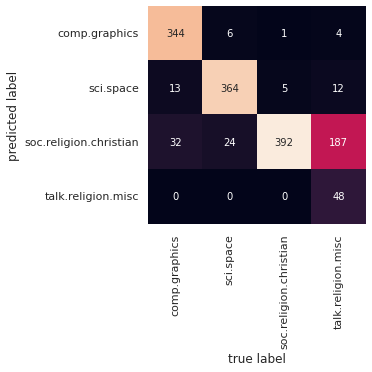

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

matrix = confusion_matrix(test.target, train_predictions)
print(matrix)
print(classification_report(test.target, train_predictions))

sns.heatmap(matrix.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=train.target_names, yticklabels=train.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');